In [166]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [182]:
def trim_attack_fn(df):
    """In column "attack_fn" of dataframe df, remove all
    superfluous characters from the attack name, leaving only
    the attack name itself.
    """
    names = ["gaussian_attack", "lie_attack", "fang_attack", "minmax_attack"]
    # remove superfluous characters from attack names in df
    for name in names:
        df.loc[df["attack_fn"].str.contains(name), "attack_fn"] = name
    names = {"gaussian_attack": "GAUSS", "lie_attack": "LIE", "fang_attack": "OPT", "minmax_attack": "AGR-MM"}
    # rename attack names in df
    for name in names:
        df.loc[df["attack_fn"].str.contains(name), "attack_fn"] = names[name]
    return df

def dataset_name_cleaner(df):
    names = {"mnist": "MNIST", "cifar": "CIFAR-10", "income": "Income", "house": "California Housing"}
    for name in names:
        df.loc[df["dataset_name"].str.contains(name), "dataset_name"] = names[name]
    return df

def get_max_acc(df, L=30):
    """Return the maximum accuracy achieved in each experiment after L rounds (i.e. bootstrap rounds).
    """
    df = df.loc[df["round"] == L]
    max_acc = df.sort_values(by='accuracy', ascending=False).groupby(['dataset_name', 'attack_fn', 'num_malicious']).first().reset_index()
    return max_acc

def add_missing_no_attacks(df):
    """To save time, I didn't run experiments with num_malicious = 0
    for all datasets. This function adds those missing rows to the
    dataframe.
    """
    df_lie = df.loc[df["num_malicious"] == 0].assign(attack_fn="LIE", ignore_index=True)
    df_opt = df.loc[df["num_malicious"] == 0].assign(attack_fn="OPT", ignore_index=True)
    df_agr = df.loc[df["num_malicious"] == 0].assign(attack_fn="AGR-MM", ignore_index=True)
    df = pd.concat([df, df_lie, df_opt, df_agr], ignore_index=True)
    return df

def compute_mape(x):
    """Flip MAPE values (i.e. 1 - MAPE) for the sake of representation.
    """
    if x['dataset_name'] == 'California Housing':
        return 1 - x['auc']
    return x['auc']

## Maximum Accuracy

In [263]:
df = pd.read_csv('../results/all_results.csv')

df = trim_attack_fn(df)
df = dataset_name_cleaner(df)
df = get_max_acc(df)
df = add_missing_no_attacks(df)
df

,dataset_name,attack_fn,num_malicious,round,auc,accuracy,loss,ignore_index
0,Income,AGR-MM,2,30,0.737702,0.795966,0.487117,NaN
1,Income,AGR-MM,3,30,0.698963,0.786036,0.507417,NaN
2,Income,AGR-MM,4,30,0.758352,0.794124,0.480669,NaN
3,Income,AGR-MM,5,30,0.728833,0.776515,0.499840,NaN
4,Income,AGR-MM,6,30,0.789540,0.801699,0.473770,NaN
...,...,...,...,...,...,...,...,...
74,MNIST,LIE,0,30,0.969422,0.945500,61.264663,True
75,Income,OPT,0,30,0.755196,0.793202,0.489739,True
76,MNIST,OPT,0,30,0.969422,0.945500,61.264663,True
77,Income,AGR-MM,0,30,0.755196,0.793202,0.489739,True


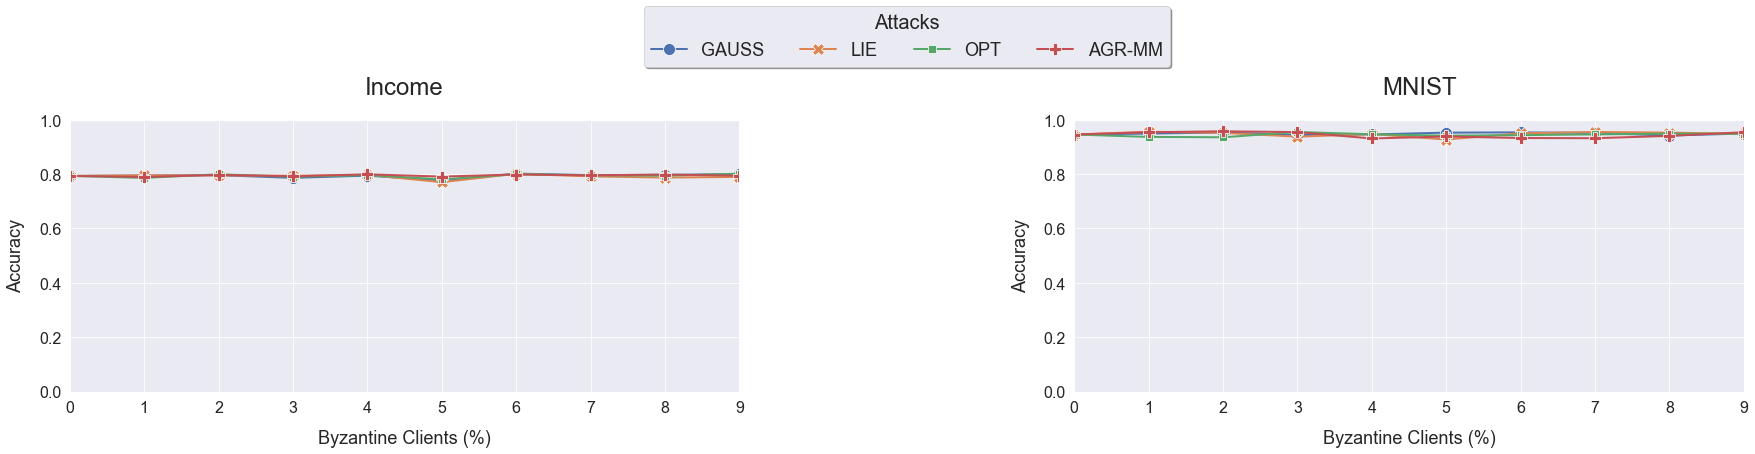

In [264]:
# Global settings
sns.set_theme()
sns.set_context("paper", font_scale=1.5)

dataset_names = ["Income", "MNIST"]
attack_names = ["GAUSS", "LIE", "OPT", "AGR-MM"]

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 5))

for i in range(len(dataset_names)):
    p = df.loc[df.dataset_name == dataset_names[i]]
    ax = sns.lineplot(data=p, x='num_malicious', y='accuracy', hue="attack_fn", ax=axes[i], 
                      style="attack_fn", markers=True, dashes=False, lw=2, markersize=12)
          
    _ = ax.tick_params(axis='both', which='major', labelsize=16)
    _ = ax.set_xlim([0,9])
    _ = ax.set_ylim([0,1])

    if i == 1:
        handles, lables = ax.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(12)
            h.set_linewidth(2)

        # replace legend using handles and labels from above
        _ = ax.legend(handles,
                   attack_names,   
              title="Attacks",
              title_fontsize=20,
              fontsize=18, 
              loc='upper center', 
              bbox_to_anchor=(-0.25, 1.45), 
              ncol=4, 
              fancybox=True, 
              shadow=True)
    else:
        _ = ax.get_legend().remove() 

_ = axes[0].set_ylabel('Accuracy', labelpad=14, fontsize=18)
_ = axes[1].set_ylabel('Accuracy', labelpad=14, fontsize=18)
_ = axes[0].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)
_ = axes[1].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)

plt.figtext(0.28,1, "Income", ha="center", va="top", fontsize=24)
plt.figtext(0.75,1, "MNIST", ha="center", va="top", fontsize=24)

plt.subplots_adjust(wspace=0.5)

plt.savefig('../_static/max_acc.jpg', bbox_inches='tight')

## Box Plots

In [270]:
df = pd.read_csv('../results/all_results.csv')

df = trim_attack_fn(df)
df = dataset_name_cleaner(df)
df = add_missing_no_attacks(df)

df

,num_malicious,attack_fn,dataset_name,round,auc,accuracy,loss,ignore_index
0,0,GAUSS,Income,0,0.500000,0.753788,0.693147,NaN
1,0,GAUSS,Income,1,0.768296,0.803952,0.478740,NaN
2,0,GAUSS,Income,2,0.714967,0.792486,0.495205,NaN
3,0,GAUSS,Income,3,0.727329,0.792383,0.491356,NaN
4,0,GAUSS,Income,4,0.693339,0.793817,0.504776,NaN
...,...,...,...,...,...,...,...,...
4024,0,AGR-MM,MNIST,46,0.959486,0.928900,121.274065,True
4025,0,AGR-MM,MNIST,47,0.963126,0.934700,111.445393,True
4026,0,AGR-MM,MNIST,48,0.964410,0.937500,105.190672,True
4027,0,AGR-MM,MNIST,49,0.968121,0.942900,94.859190,True


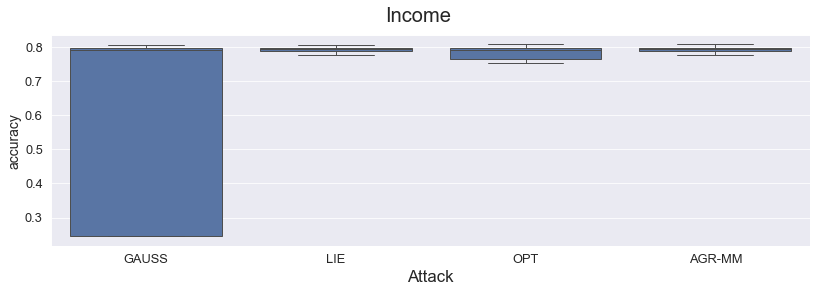

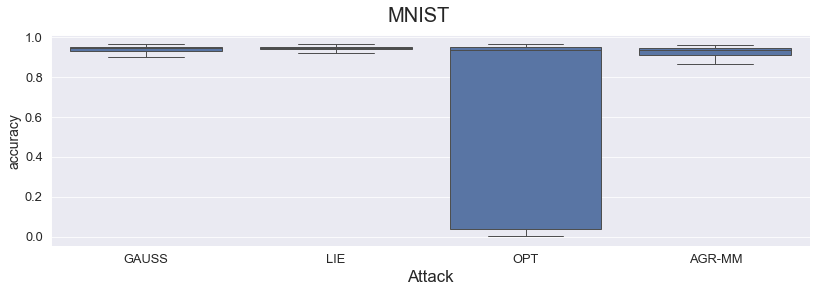

In [271]:
dataset_names = ["Income", "MNIST"]


for _, dataset in enumerate(dataset_names):
    dfl = df.loc[df.dataset_name == dataset]
    # only consider the rounds where the attack takes place
    dfd = dfl.loc[dfl["round"] >= 30]
    name = y = 'accuracy'

    sns.set_style('darkgrid')
    plt.figure(figsize=(14, 4), dpi=70)
    plt.gcf().suptitle(dataset, fontsize="x-large")

    ax = sns.boxplot(data=dfd, x="attack_fn", y=y, fliersize=0)
    # set labels
    ax.set_xlabel("Attack", fontsize="large")
    plt.savefig(f"../_static/boxplot_{dataset}.jpg", bbox_inches='tight')